In [4]:
# read in data
import json
file_path = 'inference_qa_split_100_qa10.json'
datas = []
with open(file_path, 'r') as file:
    for data in file:
        datas.append(json.loads(data))

        
print(len(datas))

100


In [5]:
datas[0].keys()

dict_keys(['filename', 'paper', 'num_Q&A', 'Q&A'])

In [6]:
datas = datas[:50]
len(datas)

50

### Calculate Attention

#### Method 1: Attention with two individual sentences

In [29]:
# attention
from transformers import AutoTokenizer, AutoModel, utils
import torch
utils.logging.set_verbosity_error()
tokenizer = AutoTokenizer.from_pretrained("/fl/model/vicuna/vicuna2_gadi_2048/")
model = AutoModel.from_pretrained("/fl/model/vicuna/vicuna2_gadi_2048/", output_attentions=True, device_map="auto")

sep_token = '[SEP]'
tokenizer.add_special_tokens({'additional_special_tokens': [sep_token]})
model.resize_token_embeddings(len(tokenizer))

def cal_attention(sentence_a, sentence_b):
    input_ids = tokenizer.encode(sentence_a + sep_token + sentence_b, return_tensors='pt')
    outputs = model(input_ids)
    attention = outputs[-1]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    sep_index = tokens.index(sep_token)
    sentence_a_indices = range(1, sep_index)
    sentence_b_indices = range(sep_index + 1, len(tokens))
    # Extract attention from sentence A to sentence B
    sentence_a_to_b_attention = attention[-1][0].sum(dim=0)[sentence_b_indices, :][:, sentence_a_indices]
#     return sentence_a_to_b_attention.mean(dim=0).detach().numpy()[1:]
#     file_path = 'attention_prompt_QA.pth'
#     torch.save(sentence_a_to_b_attention, file_path)
    return tokens[1:sep_index], sentence_a_to_b_attention

In [44]:
# input vs qa
import numpy as np
import os


def cal_att(data, dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f"Directory created: {dir}")
    else:
        print(f"Directory already exists: {dir}")

    a_li = [f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

    ### Instruction:
    <s> Here is a scientific papar.
    {data['paper'][0].replace(' but wait, I have more information to add, just answer with YES', '')}
    """]
    for i in data['paper'][1:-1]:
        a_li.append(i.replace(' but wait, I have more information to add, just answer with YES', ''))

    a_li.append(f"""{data['paper'][-1]}
    ### Input:

    ### Response:""")
    # print(a_li)
    # a_li.append(datas[data_idx]['paper'][-1].replace(" \nNow, please generate 10 scientific Q&A (prompts with outputs) using the information in the scientific paper. \nDon't ask very simple questions, like definition questions (e.g. What is XXX). You should generate more complex problems. The question is better to be related with compound name (eg. Al2O3, C2H5OH, TNT...). DO NOT generate duplicated Q&A pairs. DO NOT repeat the instruction or input. Answer using the data from input information. Add details to answers as much as possible, such as answer the specific chemical elements and numbers. \n\n<\\s>", ''))

    for idx, qa in enumerate(data['Q&A']):
        b = f'Q: {qa["Q"]}\nA: {qa["A"]}'
        att_all = None
        token_li = []
        for a in a_li:
            token, att = cal_attention(a, b)
            if att_all is None:
                att_all = att.detach().numpy()
            else:
                att_all = np.concatenate((att_all, att.detach().numpy()), axis=1)
            token_li += token

        file_path = f'{dir}/QA{idx+1}.pth'
        torch.save(att_all, file_path)
    file_path = f'{dir}/token.txt'
    with open(file_path, 'w') as file:
        for item in token_li:
            file.write(item + '\n')

In [6]:
from tqdm.notebook import tqdm

print(len(datas))
for i in tqdm(range(len(datas))):
    data = datas[i]
    fn = data['filename'].split('/')[-1].replace('.txt', '')
    dir = f'attention_result/{i}.{fn}_with_instruct'
#     dir = 'att_for_test_paper(10.1016-j.apsusc.2014.01.144)'
    cal_att(data, dir)

50


  0%|          | 0/36 [00:00<?, ?it/s]

Directory already exists: attention_result/14.10.1016-j.apcatb.2022.121765_with_instruct
Directory created: attention_result/15.10.1016-j.apcatb.2021.119926_with_instruct
Directory created: attention_result/16.10.1016-j.apsusc.2020.145638_with_instruct
Directory created: attention_result/17.10.1016-j.apsusc.2023.156341_with_instruct
Directory created: attention_result/18.10.1016-j.apsusc.2019.144225_with_instruct
Directory created: attention_result/19.10.1016-j.arabjc.2016.01.006_with_instruct
Directory created: attention_result/20.10.1016-j.apsusc.2018.05.023_with_instruct
Directory created: attention_result/21.10.1016-j.apsusc.2020.148042_with_instruct
Directory created: attention_result/22.10.1016-j.apsusc.2013.03.175_with_instruct
Directory created: attention_result/23.10.1016-j.apsusc.2019.144327_with_instruct
Directory created: attention_result/24.10.1016-j.apenergy.2019.114429_with_instruct
Directory created: attention_result/25.10.1016-j.apsusc.2017.01.269_with_instruct
Directo

#### Method 2: Attention for input and genrated output

In [128]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = '/fl/model/vicuna/vicuna2_gadi_2048/' 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, device_map='auto')
model.eval()

def cal_generation_attention(a, max_new_tokens=250, temperature=0.8, top_k=40, repetition_penalty=1.0):
    input_ids = tokenizer.encode(a, return_tensors="pt").to("cuda")
    input_length = input_ids.size(1)
    eos_token_id = tokenizer.eos_token_id

    all_attention_scores = []
    generated_tokens = []

    num_heads = model.config.num_attention_heads
    heads_attention = [[] for _ in range(num_heads)]

    for _ in range(max_new_tokens):
        outputs = model(input_ids, output_attentions=True)
        next_token_logits = outputs.logits[:, -1, :]

        # Apply repetition penalty
        for token_id in set(input_ids[0].tolist()):
            next_token_logits[0, token_id] /= repetition_penalty

        # Apply temperature
        next_token_logits = next_token_logits / temperature

        # Filter with top-k
        top_k_indices = torch.topk(next_token_logits, top_k).indices
        filtered_logits = torch.zeros_like(next_token_logits).scatter(1, top_k_indices, next_token_logits.gather(1, top_k_indices))
        next_token_probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(next_token_probs, 1)

        if next_token.item() == eos_token_id:
            break

        # add input tokens for next iteration and generate tokens
        input_ids = torch.cat([input_ids, next_token], dim=-1)
        generated_tokens.append(next_token.item())

        # Extract attention scores from the last layer for each head
        last_layer_attention = outputs.attentions[-1][0]

        for head in range(num_heads):
            head_attention = last_layer_attention[head, -1, :input_length]
            heads_attention[head].append(head_attention.detach().cpu().numpy())    # num_heads * output * input

    generated_text = tokenizer.decode(generated_tokens)
    return input_ids[0], generated_text, np.sum(np.array(heads_attention), axis=0)

### Visulise attention and token

#### Visualization for method 1

In [42]:
# visualization
import matplotlib.pyplot as plt
import torch
import json
import numpy as np
import os

def draw_plot(data, path):
    # Set up a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Adjust figsize as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing as needed

    num = data['num_Q&A']
    for i in range(1, 10):
        file_path = f'{path}/QA{i}.pth'
        attention = torch.load(file_path)
        attention = np.mean(attention, axis=0)

        row = (i - 1) // 3
        col = (i - 1) % 3
        ax = axes[row, col]
        ax.plot(range(len(attention)), attention)

        ax.set_title(f'QA{i}')
        ax.set_ylim(0, round(max(attention)*1.1,1))
    #     ax.axhline(y=0.15, color='r', linestyle='--')
    #     ax.axhline(y=1.5, color='r', linestyle='--')
        ax.set_xlabel('Token Length')
        ax.set_ylabel('Attention Score')

    # Show the plot
#     plt.show()
    plt.savefig(f'{path}/fig.png')
    plt.close(fig)

    ##### token ######
    file_path = f'{path}/token.txt'
    with open(file_path, 'r') as file:
        tokens = file.readlines()

    select_tokens = {''.join(tokens[c-5:c+6]).replace('\n', ''):str((c, score)) for c, score in enumerate(attention) if score >= 0.1}

    select_tokens_pth = f'{path}/token_att(0.1).json'

    with open(select_tokens_pth, 'w') as json_file:
        json.dump(select_tokens, json_file, indent=4)

In [43]:
from tqdm.notebook import tqdm

for i in tqdm(range(len(datas))):
    data = datas[i]
#     fn = data['filename'].split('/')[-1].replace('.txt', '')
#     path = f'attention_result/{i}.{fn}_with_instruct'
    path = f'att_for_test_paper(10.1016-j.apsusc.2014.01.144)'
    draw_plot(data, path)

  0%|          | 0/1 [00:00<?, ?it/s]

#### Visualization for method 2

In [94]:
a = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

    ### Instruction:
    Your are an expert of material science.
    
    ### Input:
    Please answer the question: What are the main factors that contribute to the reduction of the reflection coefficient when using Nb2O5 as an antireflective layer?
    
    ### Response:
    """

input_ids, generated_text, attention = cal_generation_attention(a)
mean_ba = np.mean(attention, axis=0)

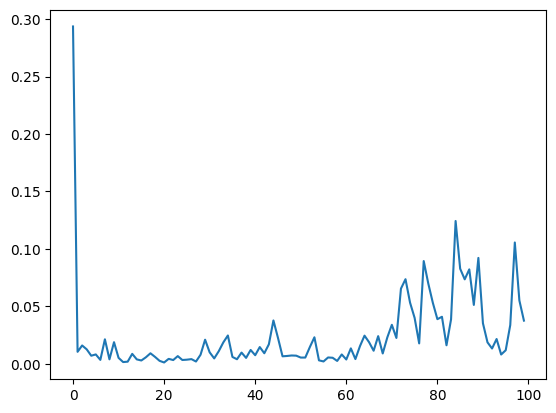

In [100]:
plt.plot(range(len(mean_ba)-1), mean_ba[1:])

In [155]:
offsets = tokenizer(a, return_offsets_mapping=True)["offset_mapping"]
offsets_highlight = [offsets[i] for i in idxs]

In [170]:
def insert_special_chars(text, offsets):
    # Sort the offsets in reverse based on the start position
    idx_num = len(offsets)
    sorted_offsets = sorted(offsets, key=lambda x: x[0], reverse=True)

    for offset in sorted_offsets:
        start, end = offset
        if start >= end:
            idx_num -= 1
        else:
            text = text[:end] + '>' + text[end:]
            text = text[:start] + '<' + text[start:]

    return text, idx_num

process_text, idx_num = insert_special_chars(a, offsets_highlight)

(0.0, 1.0, 0.0, 1.0)

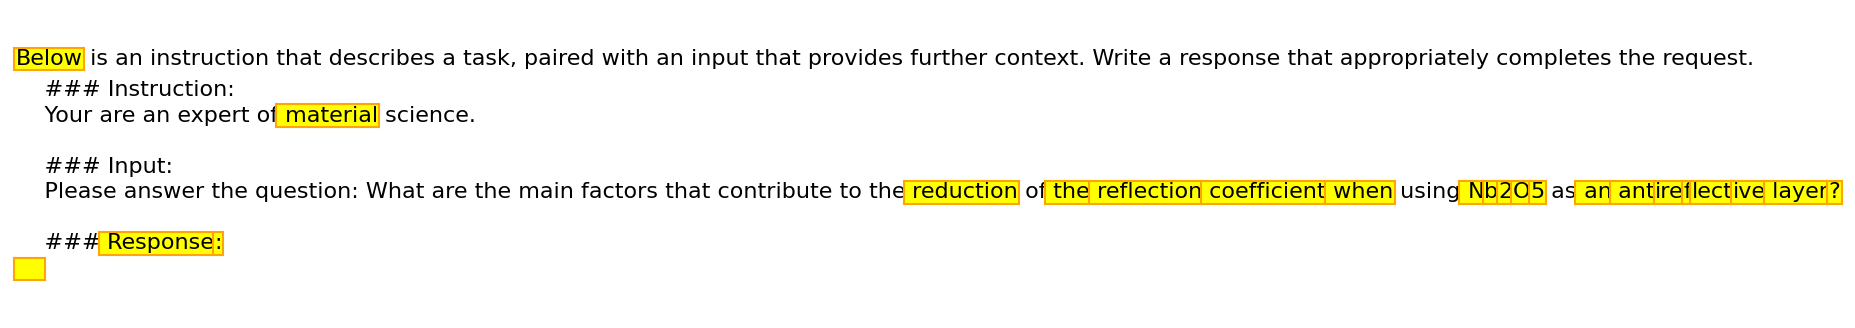

In [172]:
highlight_textprops =\
[{"bbox": {"edgecolor": "orange", "facecolor": "yellow", "linewidth": 1.5, "pad": 1}}] * idx_num

fig, ax = plt.subplots(figsize=(4, 4))  

HighlightText(x=0.5, y=0.5,
              fontsize=16,
              ha='center', va='center',
              s=process_text,
              highlight_textprops=highlight_textprops,
              ax=ax)
ax.axis('off')